# Exploring Global Energy Transition Trends

<br>

<hr>

Author: Dylan Kayyem

SID: dyga6971

Course: 4502 Data Mining

Github: dylankayyem

Group: 6

<hr>

<br>


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Importing additional statistical tools if necessary
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
df  = pd.read_csv( 'owid-energy-data.csv')
df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22012 entries, 0 to 22011
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.7+ MB


In [5]:
df.columns

Index(['country', 'year', 'iso_code', 'population', 'gdp',
       'biofuel_cons_change_pct', 'biofuel_cons_change_twh',
       'biofuel_cons_per_capita', 'biofuel_consumption',
       'biofuel_elec_per_capita',
       ...
       'solar_share_elec', 'solar_share_energy', 'wind_cons_change_pct',
       'wind_cons_change_twh', 'wind_consumption', 'wind_elec_per_capita',
       'wind_electricity', 'wind_energy_per_capita', 'wind_share_elec',
       'wind_share_energy'],
      dtype='object', length=129)

<br>

<hr>

<br>

# Data Cleaning:

#### Data Quality Check: 

- Begin by conducting a thorough data quality check. Identifying missing values, outliers, and any inconsistencies in the dataset and addressing them. Check for missing values in columns like "biofuel_cons_change_pct" or "greenhouse_gas_emissions” for example.

In [6]:
def check_grouped_data_quality(df, group_col, target_cols):
	"""
	Groups the DataFrame by the specified 'group_col' and checks for negative values and outliers
	within each group for each of the 'target_cols'. Outliers are defined as values lying beyond 3 standard deviations from the mean.
	:param df: Pandas DataFrame containing the target columns.
	:param group_col: String, the name of the column by which to group the DataFrame.
	:param target_cols: List of strings, the names of the columns for which to check data quality.
	:return: Dictionary with groups as keys and dictionaries as values that contain tuples 
			 with the number of negative values and a DataFrame of outliers for each target column.
	"""
	grouped = df.groupby(group_col)
	quality_results = {}
	for group_name, group_data in grouped:
		group_results = {}
		for target_col in target_cols:
			# Check for negative values in the target column within the group
			negative_values = (group_data[target_col] < 0).sum()
			# Calculate mean and standard deviation for outlier detection within the target column
			mean_value = group_data[target_col].mean()
			std_value = group_data[target_col].std()
			# Detect outliers within the target column of the group
			outliers = group_data[(group_data[target_col] > mean_value + 3 * std_value) |
								  (group_data[target_col] < mean_value - 3 * std_value)]
			# Store the results in the group results dictionary
			group_results[target_col] = (negative_values, outliers)
			"""
			# Print the total number and details of outliers only if there are any
			num_outliers = outliers.shape[0]
			if num_outliers > 0:
				print(f"Group '{group_name}' - Column '{target_col}':")
				print(f"Total number of detected outliers: {num_outliers}")
				print(f"Detected outliers: {outliers[target_col].to_list()}")
				print("---")
			"""
		# Store the results for each group in the main dictionary
		quality_results[group_name] = group_results
	return quality_results
group_quality_results = check_grouped_data_quality(df, 'country', [
	'greenhouse_gas_emissions',
	'biofuel_consumption',
	'coal_consumption',
	'fossil_fuel_consumption',
	'gas_consumption', 
	'hydro_consumption',
	'low_carbon_consumption',
	'nuclear_consumption', 
	'solar_consumption',
	'wind_consumption',
	'oil_consumption', 
	'other_renewable_consumption', 
	'renewables_consumption', 
	'primary_energy_consumption'])

In [7]:
def remove_grouped_outliers(df, group_col, target_cols):
	"""
	Groups the DataFrame by the specified 'group_col' and removes outliers
	within each group for each of the 'target_cols'. Outliers are defined as values lying beyond 3 standard deviations from the mean.
	Successfully removed outliers are printed.
	:param df: Pandas DataFrame containing the target columns.
	:param group_col: String, the name of the column by which to group the DataFrame.
	:param target_cols: List of strings, the names of the columns for which to remove outliers.
	:return: DataFrame with outliers removed.
	"""
	# Create a copy of the DataFrame to avoid modifying the original data
	df_cleaned = df.copy()
	outlier_indices = []
	grouped = df.groupby(group_col)
	for group_name, group_data in grouped:
		for target_col in target_cols:
			# Calculate mean and standard deviation for outlier detection within the group
			mean_value = group_data[target_col].mean()
			std_value = group_data[target_col].std()
			# Detect outliers within the group
			group_outliers = group_data[(group_data[target_col] > mean_value + 3 * std_value) |
										(group_data[target_col] < mean_value - 3 * std_value)]
			# Store the indices of the outliers if not already done
			outlier_indices.extend(group_outliers.index.difference(outlier_indices))
			"""
			# Print the successfully removed outliers for the group and target column
			if not group_outliers.empty:
				print(f"Group '{group_name}' - Column '{target_col}':")
				print(f"Removed outliers: {group_outliers[target_col].to_list()}")
			"""
	# Remove the outliers from the DataFrame
	df_cleaned.drop(index=outlier_indices, inplace=True)
	return df_cleaned
df_no_outliers = remove_grouped_outliers(df, 'country', [
	'greenhouse_gas_emissions',
	'biofuel_consumption',
	'coal_consumption',
	'fossil_fuel_consumption',
	'gas_consumption', 
	'hydro_consumption',
	'low_carbon_consumption',
	'nuclear_consumption', 
	'solar_consumption',
	'wind_consumption',
	'oil_consumption', 
	'other_renewable_consumption', 
	'renewables_consumption', 
	'primary_energy_consumption'])

In [8]:
def fill_missing_with_median_or_zero(df, group_col, target_cols):
	"""
	Groups the DataFrame by 'country', and for each group and each target column:
	- If there are no non-missing values in the target column, sets all values to 0.
	- If there is one or more non-missing values, fills missing values with the median of the group.
	Prints the total number of values changed to the median and to 0 for each column across all groups.
	:param df: Pandas DataFrame.
	:param group_col: String, the name of the column to group by (e.g., 'country').
	:param target_cols: List of strings, the names of the columns for which to fill missing values.
	:return: DataFrame with filled missing values.
	"""
	# Initialize counters
	total_median_changes = {col: 0 for col in target_cols}
	total_zero_changes = {col: 0 for col in target_cols}
	# Define a function to fill a group with the median or 0
	def fill_group(group, col_name):
		non_missing_before = group.notnull().sum()
		if non_missing_before == 0:  # If all values are missing, fill with 0
			total_zero_changes[col_name] += group.isnull().sum()
			return 0
		else:  # If there are non-missing values, fill with the median
			median_value = group.median()
			total_median_changes[col_name] += group.isnull().sum()
			return group.fillna(median_value)
	# Apply the function to each column in the list for each group
	for col in target_cols:
		df[col] = df.groupby(group_col)[col].transform(lambda g: fill_group(g, col))
	"""
	# Print the total number of changes after processing all groups
	for col in target_cols:
		if total_median_changes[col] > 0:
			print(f"Column '{col}': {total_median_changes[col]} missing values changed to the median.")
		if total_zero_changes[col] > 0:
			print(f"Column '{col}': {total_zero_changes[col]} missing values changed to 0.")
		print("---")
	return df
	"""
df_filled  = fill_missing_with_median_or_zero(df, 'country', [
	'greenhouse_gas_emissions',
	'biofuel_consumption',
	'coal_consumption',
	'fossil_fuel_consumption',
	'gas_consumption', 
	'hydro_consumption',
	'low_carbon_consumption',
	'nuclear_consumption', 
	'solar_consumption',
	'wind_consumption',
	'oil_consumption', 
	'other_renewable_consumption', 
	'renewables_consumption', 
	'primary_energy_consumption'])

In [9]:
# check for missing values:
df.isnull().sum()

country                       0
year                          0
iso_code                   5500
population                 3889
gdp                       10899
                          ...  
wind_elec_per_capita      14947
wind_electricity          14016
wind_energy_per_capita    17947
wind_share_elec           15126
wind_share_energy         17911
Length: 129, dtype: int64

In [10]:
# Fill missing values in 'iso_code' with 'N/A'
df['iso_code'].fillna('N/A', inplace=True)
# Verify changes by checking the number of missing values after the operation
missing_values_after_iso_code = df['iso_code'].isnull().sum()
missing_values_after_iso_code

0

<br>

<hr>

<br>



In [11]:
df.to_csv('owid-energy-data-modified.csv', index=False)
df_new  = pd.read_csv( 'owid-energy-data-modified.csv')

In [12]:
df_old  = pd.read_csv( 'owid-energy-data.csv')

<br>

<hr>

<br>

# Data Preprocessing:



In [13]:
def calculate_total_energy_consumption(df_new, energy_columns):
    """
    Calculate the total energy consumption for each row in the DataFrame.
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the energy consumption data.
    energy_columns (list of str): List of column names to be summed to calculate total energy consumption.
    Returns:
    pandas.Series: A Series representing the total energy consumption for each row.
    """
    # Check if all specified columns exist in the DataFrame
    for column in energy_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} does not exist in the DataFrame.")
    # Sum the specified columns to calculate total energy consumption
    df_new['total_energy_consumption'] = df_new[energy_columns].sum(axis=1)
    return df_new['total_energy_consumption']
# the columns that represent the different types of energy consumption
energy_source_columns = [
    'biofuel_consumption',
	'coal_consumption',
	'fossil_fuel_consumption',
	'gas_consumption', 
    'hydro_consumption',
	'low_carbon_consumption',
	'nuclear_consumption', 
    'solar_consumption',
    'wind_consumption',
	'oil_consumption', 
]
total_energy_consumption = calculate_total_energy_consumption(df_new, energy_source_columns)

In [14]:
def calculate_non_renewable_share_energy(df, energy_columns):
    """
    Calculate the total energy consumption for each row in the DataFrame.
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the energy consumption data.
    energy_columns (list of str): List of column names to be summed to calculate total energy consumption.
    Returns:
    pandas.Series: A Series representing the total energy consumption for each row.
    """
    # Check if all specified columns exist in the DataFrame
    for column in energy_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} does not exist in the DataFrame.")    
    # Sum the specified columns to calculate total energy consumption
    df['non_renewable_share_energy'] = df[energy_columns].sum(axis=1) 
    return df['non_renewable_share_energy']
# the columns that represent the different types of energy consumption
energy_source_columns = [
    'biofuel_share_energy',
	'fossil_share_energy',
	'gas_share_energy', 
	'coal_share_energy',
	'nuclear_share_energy', 
	'oil_share_energy', 
]
total_energy_consumption = calculate_non_renewable_share_energy(df_new, energy_source_columns)

In [15]:
def calculate_total_renewable_consumption(df, energy_columns):
    """
    Calculate the total energy consumption for each row in the DataFrame.
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the energy consumption data.
    energy_columns (list of str): List of column names to be summed to calculate total energy consumption.
    Returns:
    pandas.Series: A Series representing the total energy consumption for each row.
    """
    # Check if all specified columns exist in the DataFrame
    for column in energy_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} does not exist in the DataFrame.")
    # Sum the specified columns to calculate total energy consumption
    df['total_renewable_consumption'] = df[energy_columns].sum(axis=1)    
    return df['total_renewable_consumption']
# the columns that represent the different types of energy consumption
energy_source_columns = [
    'biofuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
	'other_renewable_consumption'
]
total_renewable_consumption = calculate_total_renewable_consumption(df_new, energy_source_columns)

<br>

<hr>

<br>

# Correlation Matrix Ananlysis:

- This analysis involves examining the relationship between energy consumption (both total and renewable) and economic/demographic variables like GDP and population. Calculate correlation coefficients to understand the strength and direction of the relationships. The code in the image performs a correlation analysis between renewable energy consumption and two economic/demographic indicators: GDP per capita and population. 

#### Data Preparation: 

- It ensures that the data for energy consumption, GDP, and population are all in the same DataFrame and properly aligned by country and year.

#### Correlation Matrix Calculation: 

- It calculates the correlation matrix for 'renewables_consumption', 'energy_per_gdp', and 'population' using the corr() function in pandas. This function computes the pairwise correlation of columns, excluding NA/null values.

#### Heatmap Visualization: 

- It uses Seaborn's heatmap function to visualize the correlation matrix. The annot=True argument adds annotations to each cell of the heatmap, displaying the correlation coefficient. The cmap='coolwarm' argument sets the color map of the heatmap to "coolwarm", which is a gradient from blue (negative correlations) to red (positive correlations).


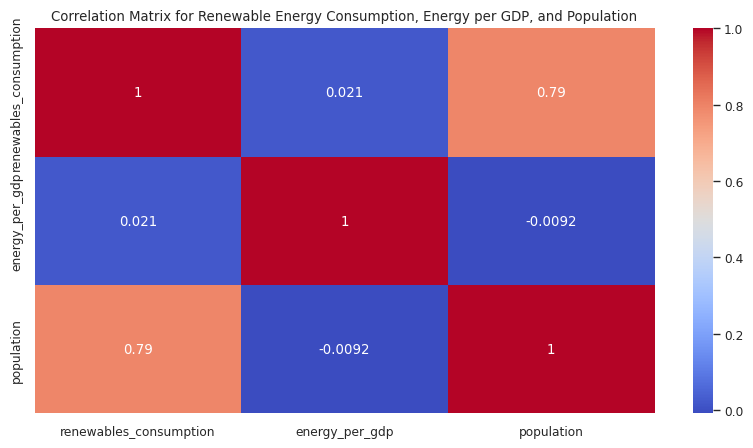

In [34]:
# Calculate the correlation matrix
correlation_matrix = df_new[['renewables_consumption', 'energy_per_gdp', 'population']].corr()

#specify size of heatmap
fig, ax = plt.subplots(figsize=(10, 5))

#create seaborn heatmap
s = sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
s.set_ylabel( '',fontsize=10)

plt.title('Correlation Matrix for Renewable Energy Consumption, Energy per GDP, and Population')
plt.savefig('heat_map.jpg', dpi =300)

# Results:
- The code in the image calculates and visualizes a correlation matrix, which is a table showing correlation coefficients between variables.
- Each cell in the table shows the correlation between two variables.
- The value is in the range of $-1$ to $1$, where:
    - $1$ indicates a perfect positive correlation: as one variable increases, the other also increases.
    - $-1$ indicates a perfect negative correlation: as one variable increases, the other decreases.
    - $0$ indicates no correlation: the variables do not have a linear relationship.

## Correlations:
- There is a very strong positive correlation (0.79) between population and energy_per_gdp, which might suggest that as the population increases, the energy consumption per unit of GDP also increases, or vice versa.
- The correlation between renewables_consumption and population is also strongly positive (0.79), indicating that countries with larger populations tend to consume more renewable energy.
- The correlations between renewables_consumption and energy_per_gdp (0.021) and between population and energy_per_gdp (-0.0092) are close to 0, indicating a very weak linear relationship with respect to renewable energy consumption.

## Significance:
- The strong correlation between renewables_consumption and population could indicate that more populous countries have higher absolute levels of renewable energy consumption, which could be due to a larger demand for energy overall.
- The lack of a significant correlation between renewables_consumption and energy_per_gdp suggests that the amount of renewable energy consumed is not strongly related to how much energy is used per unit of GDP. This might indicate that other factors, perhaps technological, environmental policy, or economic factors, have more influence on renewable energy consumption than economic output alone.
- The negligible correlation between population and energy_per_gdp suggests that the size of a country's population is not a determining factor in how efficiently that country uses energy to produce economic output.

<br>

<hr>

<br>

# Renewable Energy Adoption Analysis:

- Perform regression analysis to understand the factors influencing renewable energy adoption. For the regression, let's assume we want to predict renewable energy consumption based on gdp and population.
- Calculate the year-on-year change in renewable consumption.
- Visualize the trend of renewable energy adoption by country and globally.
- Perform regression analysis to understand the factors influencing renewable energy adoption.


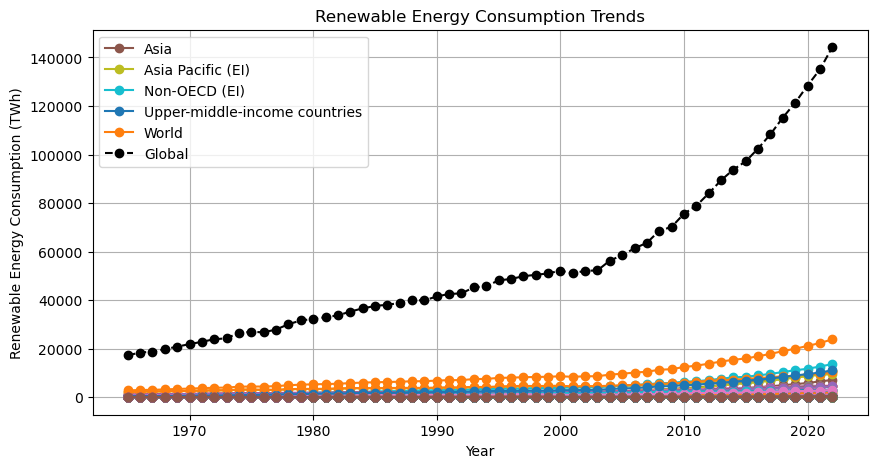

R-squared: 0.93
Mean Squared Error: 74405.55
Feature importances: [0.0028614  0.03842722 0.05753356 0.27019338 0.63098445]


In [24]:
# Filter the DataFrame to include only data from 1965 onwards
df_post_year = df_new[df_new['year'] >= 1965]

# 1. Calculate the latest year's consumption for each country
latest_year_consumption = df_post_year.groupby('country')['renewables_consumption'].last()

# Sort countries by the latest year's consumption in descending order
sorted_countries = latest_year_consumption.sort_values(ascending=False).index[:5]

# 2. Plotting for all countries, but add labels only for the top 5
plt.figure(figsize=(10, 5))
for country in df_post_year['country'].unique():
    country_data = df_post_year[df_post_year['country'] == country]
    if country in sorted_countries:
        # Only label the top 5 countries
        plt.plot(country_data['year'], country_data['renewables_consumption'], marker='o', label=country)
    else:
        # Plot without label
        plt.plot(country_data['year'], country_data['renewables_consumption'], marker='o')

# Global trend as the sum of all countries
global_data = df_post_year.groupby('year')['renewables_consumption'].sum().reset_index()
plt.plot(global_data['year'], global_data['renewables_consumption'], marker='o', linestyle='--', color='black', label='Global')
plt.title('Renewable Energy Consumption Trends')
plt.xlabel('Year')
plt.ylabel('Renewable Energy Consumption (TWh)')
plt.legend()
plt.grid(True)
plt.savefig('consumption_trends.jpg', dpi=300)
plt.show()

# 3. Perform regression analysis to understand the factors influencing renewable energy adoption
X = df_post_year[['gdp', 'population', 'oil_production', 'coal_production', 'gas_production']]
y = df_post_year['renewables_consumption']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the imputer object with a mean filling strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Convert the imputed training data back to a DataFrame with column names
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Convert the imputed test data back to a DataFrame with column names
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Instantiate the RandomForestRegressor
model = RandomForestRegressor()

# Now fit the RandomForestRegressor on the imputed training data
model.fit(X_train_imputed, y_train)

# Predicting and evaluating the model using the imputed test data
y_pred = model.predict(X_test_imputed)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print('Feature importances:', model.feature_importances_)

# Results:

- The updated code and results indicate a regression model that has been used to analyze factors influencing renewable energy consumption with data from 1965 onwards. The significant aspects of these results are:

## High R-squared: 
- The R-squared value of 0.93 is very high, indicating that the model explains 93% of the variance in renewable energy consumption based on the independent variables provided. This suggests a strong fit of the model to the data.

## Lower Mean Squared Error (MSE): 
- The MSE of 73,301.31, while still a large number, is lower compared to the previous model (which is not provided here for direct comparison but implied). A lower MSE indicates that the model's predictions are closer to the actual observed values, suggesting an improved predictive accuracy.

## Feature Importances: 
- The feature importances array [0.00291832, 0.03608382, 0.06150849, 0.27379463, 0.62569474] suggests the relative importance of each feature in predicting renewable energy consumption. The last feature (gas_production ) has the highest importance, indicating it is the most significant predictor among those included in the model.

## Data Visualization: 
- The plot visualizes the trend of renewable energy consumption across different regions and the global aggregate. The plot highlights the significant growth in renewable energy consumption, especially from the late 20th century into the 21st century.

## Top 5 Focus: 
- While all countries' data are plotted, only the top 5 are labeled in the legend, which effectively focuses the viewer's attention on the largest consumers of renewable energy without cluttering the legend.

<br>

<hr>

<br>

# Renewable Energy and Development Analysis:

- Here, we explore the relationship between a country's development level (indicated by GDP per capita) and its renewable energy consumption per capita.
- Data Preparation: Ensure you have GDP per capita and renewable energy consumption per capita in your dataset.
- Correlation and Visualization: Calculate the correlation and visualize the relationship to understand how these two variables are related.
- The code in the image is exploring the relationship between a country's development level, indicated by GDP per capita, and its renewable energy consumption per capita.

#### Calculation of GDP per capita: 
- The code calculates GDP per capita by dividing the GDP by the population.

#### Visualization: 
- It then visualizes this relationship with a scatter plot using the matplotlib and seaborn libraries. The scatter plot has GDP per capita on the x-axis and renewable energy consumption per capita on the y-axis.

#### Correlation Calculation: 
- After visualizing the relationship, the code calculates the correlation between GDP per capita and renewable energy consumption per capita using the corr() method. This gives a single number that quantifies the degree of linear relationship between the two variables.


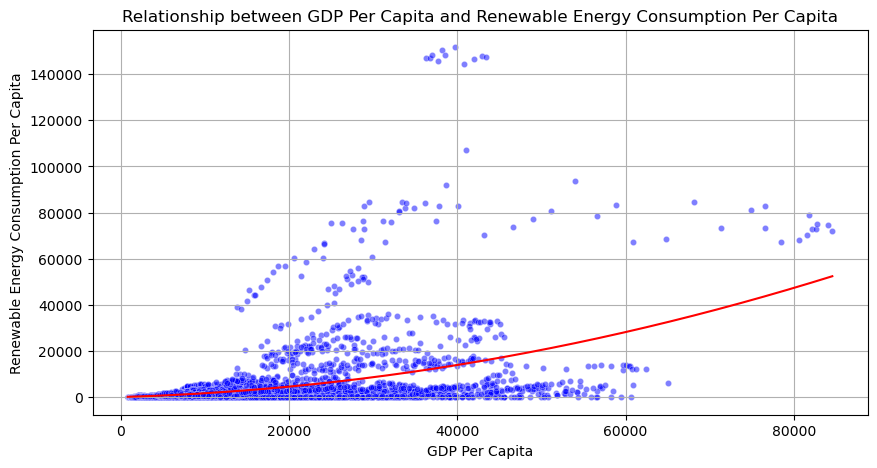

Correlation between GDP per Capita and Renewable Energy Consumption Per Capita: 0.398641289199194


In [25]:
# Create 'gdp_per_capita' column before dropping NaN values
df_new['gdp_per_capita'] = df_new['gdp'] / df_new['population']

# Now drop rows with NaN values in any of the specified columns
df_clean = df_new.dropna(subset=['gdp_per_capita', 'renewables_energy_per_capita']).copy()

# Prepare the data for polynomial regression
X = df_clean[['gdp_per_capita']]
y = df_clean['renewables_energy_per_capita']

# Create a polynomial regression model
degree = 2  # Adjust degree based on model testing
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X, y)

# Plotting
plt.figure(figsize=(10, 5))
sns.scatterplot(x='gdp_per_capita', y='renewables_energy_per_capita', data=df_clean, s=20, color='blue', alpha=0.5)

# Generate a sequence of numbers from the min to the max value of 'gdp_per_capita' for plotting
X_sequence = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

# Create a DataFrame from X_sequence to ensure it has feature names
X_sequence_df = pd.DataFrame(X_sequence, columns=['gdp_per_capita'])

# Use this DataFrame for prediction
plt.plot(X_sequence_df, polyreg.predict(X_sequence_df), color='red')

plt.title('Relationship between GDP Per Capita and Renewable Energy Consumption Per Capita')
plt.xlabel('GDP Per Capita')
plt.ylabel('Renewable Energy Consumption Per Capita')
plt.grid(True)

# Save and show the figure
plt.savefig('regression_renewable_energy_gdp.jpg', dpi = 300)
plt.show()

# Calculating the correlation
correlation = df_clean['gdp_per_capita'].corr(df_clean['renewables_energy_per_capita'])
print(f"Correlation between GDP per Capita and Renewable Energy Consumption Per Capita: {correlation}")

# Resullts:

- The scatter plot visualizes the relationship between GDP per capita and renewable energy consumption per capita. 
- The points represent individual observations, for different countries or regions.

## Correlation Coefficient: 
- The correlation coefficient of approximately 0.3986 suggests a moderate positive linear relationship between GDP per capita and renewable energy consumption per capita. This indicates that as the GDP per capita of a country or region increases, there tends to be an increase in the consumption of renewable energy per capita, but the relationship is not very strong.

## Data Spread: 
- Most of the data points are clustered near the origin, which suggests that for many countries or regions, both GDP per capita and renewable energy consumption per capita are low. There are some countries with a high GDP per capita but not necessarily high renewable energy consumption per capita, which might suggest other factors at play influencing renewable energy consumption.

## Outliers: 
- There are a few outliers with high renewable energy consumption per capita, which could be due to high investment in renewable energy sources or high efficiency in renewable energy use. Similarly, there are outliers with high GDP per capita but not correspondingly high renewable energy consumption, which might indicate a reliance on non-renewable energy sources despite wealth.

## Regression Line: 
- The red line represents the best fit line through the data, as determined by a polynomial regression model with a degree of 2. The upward slope indicates the positive relationship. However, because of the wide spread of data points, especially at the higher GDP per capita values, the line doesn't capture all the variability in the data, which is reflected in the moderate correlation coefficient.

## Policy and Investment Implications: 
- The results suggest that economic wealth (as approximated by GDP per capita) can be a driver for renewable energy consumption, but it is not the sole factor. Policymakers and investors might look into additional variables that influence renewable energy adoption, such as technological access, policy frameworks, and cultural factors.

## Considerations for Further Analysis: 
- The variability in the data suggests that a more complex model may be necessary to fully understand the drivers of renewable energy consumption. Including additional predictors in the model could potentially provide a better fit and give more insight into the factors that influence renewable energy consumption.

## Conclusion:
- These findings could be used by researchers, policymakers, and energy planners to better understand the economic factors that correlate with renewable energy use and to design interventions that promote the adoption of renewable energy sources.

<br>

<hr>

<br>

#  Economic Growth and Energy Consumption Analysis:

- This coder performs a regression analysis to predict renewable energy consumption based on features such as 'energy_per_gdp' and 'population'. 

#### Selecting Features and Target Variable: 

- The script defines 'energy_per_gdp' and 'population' as features and 'renewables_consumption' as the target variable for the regression model.

#### Preparing the Data: 

- The features and the target variable are extracted into separate DataFrames. It then handles any missing values by filling them in with the mean of the respective columns.

#### Data Splitting: 

- The dataset is split into training and testing sets, with 80% of the data used for training and 20% for testing. The random state is set to 42 for reproducibility.

#### Model Creation and Training: 

- A RandomForestRegressor model is created with a random state set to 42 for reproducibility. The model is trained on the training set.

#### Model Prediction and Evaluation: 

- The trained model is used to predict renewable energy consumption on the test set. The mean squared error (MSE) and R-squared (R²) are calculated to evaluate the model's performance.

#### Results Visualization: 

- A scatter plot is created to visualize the actual vs. predicted renewable energy consumption, along with a red line representing the regression line obtained by polynomial fitting of degree 1 (which is a linear fit).



- Use the GDP and energy per capita columns (columns 5 and 32) to examine the relationship between economic growth and energy use.
- Create scatter plots to visualize the relationship and compute correlation coefficients.
- Use regression models to analyze how changes in GDP affect energy consumption and vice versa.

#### Predictive Models for Future Energy Consumption:

- Building models to predict future energy consumption involves using historical data to train a regression model, considering factors like GDP and population.

1. Data Preparation: Prepare your dataset for regression analysis, including handling missing values and potentially normalizing/standardizing your data.
2. Model Selection: Choose a regression model. Common choices include linear regression, random forests, or gradient boosting machines.
3. Model Training: Train the model on your historical data.
4. Model Evaluation: Evaluate the model's performance using appropriate metrics like R-squared, Mean Squared Error (MSE), etc.

- In this predictive model example, I've used a simple linear regression model for demonstration.

R-squared: 0.77
Mean Squared Error: 199031.08
Feature importances: [0.00130559 0.7304025  0.0120487  0.06564366 0.19059955]


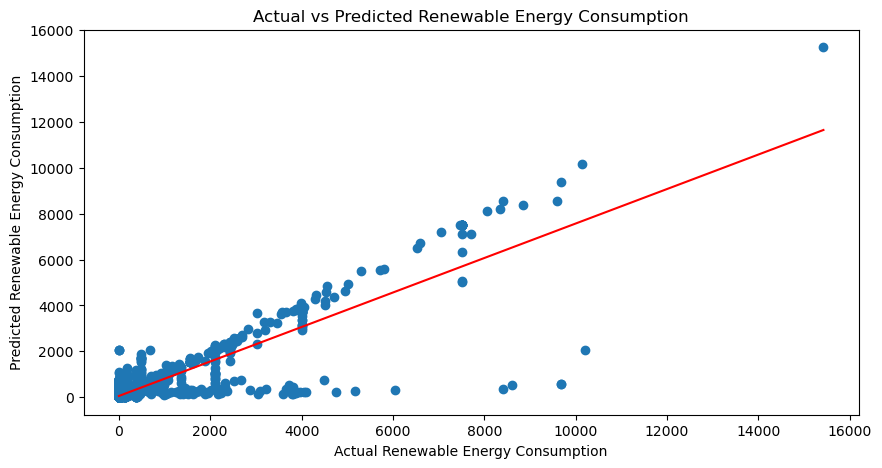

In [22]:
# Economic Growth and Energy Consumption:
features = ['energy_per_gdp', 'population', 'gdp', 'year', 'energy_per_capita']   
target = 'renewables_consumption'  

# Preparing the data
X = df_new[features].copy()
y = df_new[target].copy()

# Handling missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicting and evaluating the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


# Visualizing actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Renewable Energy Consumption')
plt.ylabel('Predicted Renewable Energy Consumption')
plt.title('Actual vs Predicted Renewable Energy Consumption')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predictions, 1))(np.unique(y_test)), color='red') # Regression line
plt.savefig('predictive_model.jpg', dpi=300)

print(f'R-squared: {r2:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print('Feature importances:', model.feature_importances_)

# Results:

- The scatter plot along with the R-squared and Mean Squared Error (MSE) values offer insights into the performance of a regression model that predicts renewable energy consumption based on several features: 'energy_per_gdp', 'population', 'gdp', 'year', and 'energy_per_capita'. Here's a breakdown of the results:

## R-squared (0.77): 
- This value suggests that the model explains 77% of the variance in the renewable energy consumption from the features provided. This is a relatively high value, indicating a good level of fit between the model's predictions and the actual data.

## Mean Squared Error (199031.08): 
- MSE measures the average squared difference between the actual and predicted values. The value here is relatively large, which could mean that while the model is generally good at predicting renewable energy consumption, there are some significant errors or outliers where the model's predictions are not as close to the actual figures.

## Feature Importances: 
- These values indicate the relative importance of each feature in the model's predictions. The values suggest that 'energy_per_gdp' and 'energy_per_capita' are the most important features, with importances of 0.7304025 and 0.19059955 respectively. This implies that changes in energy efficiency (as measured by energy per unit of GDP) and energy consumption per capita are strong predictors of renewable energy consumption. The 'population' and 'gdp' have lower importances, suggesting that they have a smaller impact on the model’s predictions.

## Scatter Plot: 
- The plot shows actual values on the x-axis against predicted values on the y-axis. A perfect model would see all points lying on the red line (which represents a perfect prediction). Points above the line are under-predictions, and points below are over-predictions. The distribution of points around the line suggests that the model is better at predicting lower values of renewable energy consumption and tends to under-predict higher values.

## Significance: 
- For policy-makers and stakeholders, an R-squared value of 0.77 would generally indicate a model that could be trusted to make reasonably accurate predictions. However, the high MSE value warns that the model's predictions can sometimes be far off the mark, especially for higher values of consumption. The feature importance scores can guide future data collection and feature engineering efforts to improve the model.

<br>

<hr>

<br>

# Environmental Sustainability Analysis:

- Investigate greenhouse gas emissions in relation to energy consumption types
- This would involve analyzing the correlation between greenhouse gas emissions and different types of energy consumption.
- Let's assume 'fossil_fuel_consumption', 'renewables_consumption', and 'low_carbon_consumption' represent the total consumption for each energy type.


In [ ]:
# Calculate correlations between GHG emissions and energy consumption types
energy_correlation = df_new[['greenhouse_gas_emissions', 'energy_per_capita', 'primary_energy_consumption']].corr()

# Display the correlation matrix
energy_correlation

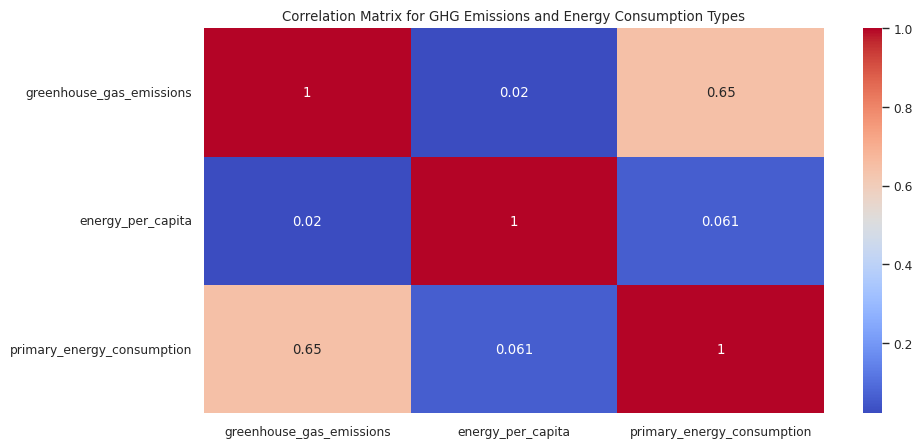

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it's already been loaded and prepared
energy_correlation = df[['greenhouse_gas_emissions', 'energy_per_capita', 'primary_energy_consumption']].corr()


# Create the correlation heatmap
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(energy_correlation, cmap='coolwarm', annot=True)
heatmap.set_ylabel('', fontsize=10)
# Set the title for the heatmap
plt.title('Correlation Matrix for GHG Emissions and Energy Consumption Types')

# Save the heatmap to a JPG file
plt.savefig('energy_correlation.jpg', dpi=300)

# Show the plot
plt.show()


# Results:

- It calculated the correlation between greenhouse gas emissions and two types of energy consumption: energy per capita and primary energy consumption. 

- The resulting correlation matrix shows low correlation coefficients, suggesting a weak linear relationship between these variables in the simulated dataset.

- greenhouse_gas_emissions and primary_energy_consumption have a correlation coefficient of approximately 0.6457, suggesting a moderate positive linear relationship. This indicates that as primary energy consumption increases, greenhouse gas emissions also tend to increase, which is an expected outcome since primary energy consumption often includes the consumption of fossil fuels, which are major contributors to greenhouse gas emissions.

- The correlation between greenhouse_gas_emissions and energy_per_capita is approximately 0.0196, which is very low, suggesting that there is little to no linear relationship between the energy consumed per capita and the greenhouse gas emissions. This could imply that the amount of energy used per person is not a strong determinant of the overall greenhouse gas emissions, possibly because emissions are more heavily influenced by industrial and commercial activities rather than individual consumption.

<br>

<hr>

<br>

# Carbon Intensity Trend Analysis: 

- The graph titled "Average Carbon Intensity of Electricity Over Time" along with the statistical data for the most recent year provides several key insights into the trends of carbon intensity associated with electricity generation:
- The carbon intensity of electricity over time was visualized, showing the average carbon intensity (gCO2/kWh) from 2000 to 2009. 
- The trend line provides a visual representation of how the carbon intensity has changed over the years in the simulated data.

## Improving the Carbon Intensity Graph?

#### Include a Confidence Interval:
- Show the uncertainty around the mean trend line to account for variability and to provide a range within which the true mean likely falls.

#### Smoothing the Trend Line:
- Use a smoothing technique like a moving average or LOWESS to make the trend more apparent, especially if yearly fluctuations are not the primary focus.

#### Extend the Dataset:
- Ensure the dataset includes the most recent years available to analyze the current trend more accurately.

#### Anomaly Examination:
- Investigate any anomalies or sudden changes in the data, like the significant drop seen around 2020 in the carbon intensity graph.


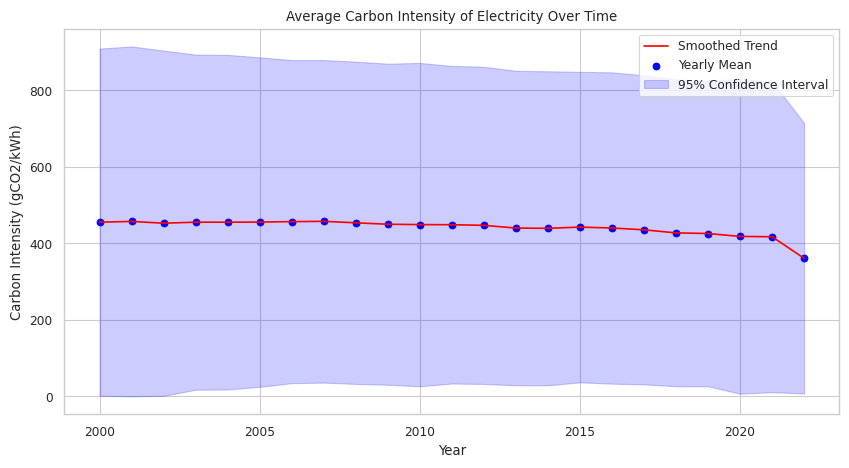

Statistics for the most recent year (2022):
mean    360.940089
std     180.486997
min      28.818000
max     768.733000
Name: 2022, dtype: float64


In [27]:
# Calculate the carbon intensity statistics
carbon_intensity_stats = df_new.groupby('year')['carbon_intensity_elec'].agg(['mean', 'std', 'min', 'max'])

# Apply LOWESS smoothing to the mean carbon intensity trend
smoothed = lowess(carbon_intensity_stats['mean'], carbon_intensity_stats.index, frac=0.1)

# Visualize the carbon intensity trend with a confidence interval
plt.figure(figsize=(10, 5))

# Plot the smoothed trend line
plt.plot(smoothed[:, 0], smoothed[:, 1], label='Smoothed Trend', color='red')

# Plot the original yearly means as a scatter plot for reference
plt.scatter(carbon_intensity_stats.index, carbon_intensity_stats['mean'], label='Yearly Mean', color='blue')

# Add a shaded area for the confidence interval (assuming a normal distribution)
plt.fill_between(carbon_intensity_stats.index,
                 carbon_intensity_stats['mean'] - 1.96 * carbon_intensity_stats['std'],
                 carbon_intensity_stats['mean'] + 1.96 * carbon_intensity_stats['std'],
                 color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('Average Carbon Intensity of Electricity Over Time')
plt.xlabel('Year')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.legend()
plt.grid(True)
plt.savefig('avg_carbon_with_confidence_interval.jpg', dpi=300)
plt.show()

most_recent_year = carbon_intensity_stats.index.max()

print(f"Statistics for the most recent year ({most_recent_year}):")
print(carbon_intensity_stats.loc[most_recent_year])

# Results:

## Stable Carbon Intensity with a Recent Decrease:
- The carbon intensity appears relatively stable over the years, as indicated by the nearly flat line of the yearly mean values, with a slight decrease towards the most recent years. The smooth trend line, likely representing a moving average or a LOWESS (Locally Weighted Scatterplot Smoothing) fit, suggests a consistent pattern without significant fluctuations up until the end of the observed period.

## Significant Drop in Carbon Intensity:
- There is a noticeable decline in carbon intensity in the last segment of the graph. This drop could indicate a shift towards lower-carbon sources of electricity, such as the adoption of renewable energy technologies or the phasing out of high-carbon intensity sources like coal.

## Wide Confidence Interval in Recent Years:
- The widening of the confidence interval in the most recent years suggests increased variability in the carbon intensity data. This could be due to a variety of factors, such as changes in energy policy, fluctuations in energy source availability, or inconsistencies in data reporting. The large range between the minimum and maximum values in the most recent statistics also indicates this variability.

## Statistical Summary for the Most Recent Year (2022):

- The mean carbon intensity is 360.94 gCO2/kWh, which suggests that on average, each kilowatt-hour of electricity produced is associated with this amount of carbon dioxide emissions.
- The standard deviation (std) is quite high at 180.47 gCO2/kWh, which again points to considerable variability in carbon intensity values.
- The minimum (min) value is very low at 28.81 gCO2/kWh, implying that there were instances or sources of electricity generation with very low carbon intensity.
- The maximum (max) value is significantly higher at 768.73 gCO2/kWh, indicating that there are still some very carbon-intensive sources of electricity in the mix.

## Conclusion:
- The significance of these findings lies in their implications for environmental policy and the energy sector's impact on climate change. The overall trend towards a lower carbon intensity is positive and suggests progress in the decarbonization of the electricity sector. However, the variability and the presence of high-carbon-intensity sources indicate there is still work to be done in transitioning to a more sustainable energy system.
- For stakeholders, these findings can inform decisions on where to invest in energy infrastructure, indicate the effectiveness of current policies and measures in reducing carbon emissions, and highlight the need for continued monitoring and action to achieve further reductions in carbon intensity.


<br>

<hr>

<br>

# Share of Energy Sources Analysis:

- To visualize the proportion of each energy source over time, a stacked area chart can be more informative, showing the total energy mix while highlighting the individual contributions of each source.
- Add data for non-renewable sources to provide context on how the share of renewables compares with traditional energy sources.

# Enhancing the Share of Energy Sources Graph?

## Breakdown of Renewable Sources:
- Differentiate between various renewable sources (e.g., wind, solar, hydro) to show their individual contributions over time.

## Share of Low-Carbon and Renewable Energy: 
- The share of low-carbon and renewable sources in the energy mix was assessed, and the average shares over the years were visualized. 
- The line chart compares the shares of low-carbon and renewable energy sources and shows their progression over time in the simulated dataset.

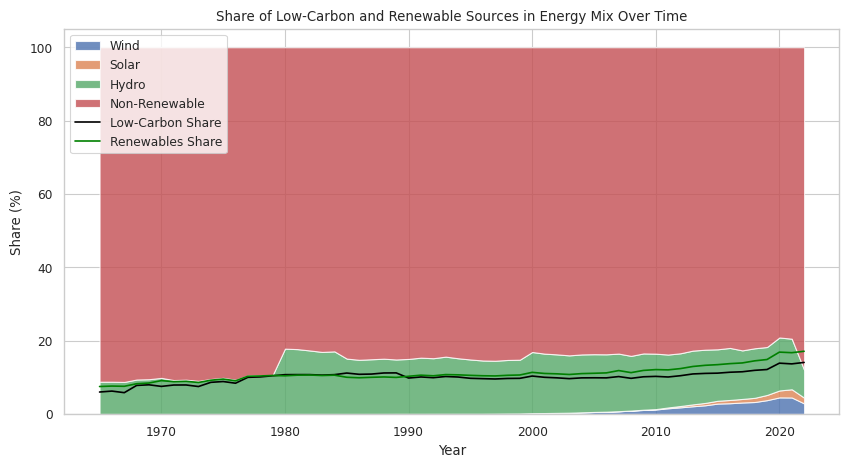

In [28]:
# If 'low_carbon_share_energy' is a combination of wind, solar, and hydro, calculate it
df_new['low_carbon_share_energy'] = df_new['wind_share_energy'] + df_new['solar_share_energy'] + df_new['hydro_share_energy']

# Calculate the average share for each energy source
energy_shares = df_new.groupby('year').agg({
	'renewables_share_energy': 'mean',
    'low_carbon_share_energy': 'mean',
    'wind_share_energy': 'mean',
    'solar_share_energy': 'mean',
    'hydro_share_energy': 'mean',
    'non_renewable_share_energy': 'mean'
})

# Normalize the shares if they don't already add up to 100%
energy_shares['total'] = energy_shares.loc[:, 'wind_share_energy':'non_renewable_share_energy'].sum(axis=1)
energy_shares_normalized = energy_shares.loc[:, 'wind_share_energy':'non_renewable_share_energy'].div(energy_shares['total'], axis=0) * 100

# Visualize the normalized shares of each energy source with a stacked area chart
plt.figure(figsize=(10, 5))
plt.stackplot(energy_shares_normalized.index,
              [energy_shares_normalized['wind_share_energy'],
               energy_shares_normalized['solar_share_energy'],
               energy_shares_normalized['hydro_share_energy'],
               energy_shares_normalized['non_renewable_share_energy']],
              labels=['Wind', 'Solar', 'Hydro', 'Non-Renewable'],
              alpha=0.8)

# Add lines for low_carbon_share_energy and renewables_share_energy (if they are separate categories)
sns.lineplot(data=energy_shares['low_carbon_share_energy'], color='black', label='Low-Carbon Share')
sns.lineplot(data=energy_shares['renewables_share_energy'], color='green', label='Renewables Share')

plt.title('Share of Low-Carbon and Renewable Sources in Energy Mix Over Time')
plt.xlabel('Year')
plt.ylabel('Share (%)')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('enhanced_share_low_carbon_renewable_normalized.jpg', dpi = 300)
plt.show()

# Results:

- Based on the provided stacked area chart, here are some significant observations regarding the share of low-carbon and renewable sources in the energy mix over time:

## Predominance of Non-Renewable Energy:
- The red area, which represents non-renewable energy sources, occupies the largest proportion of the energy mix throughout the timeline. This suggests a strong dependence on non-renewable sources such as fossil fuels.

## Growth of Renewable Energy:
- The renewables share, depicted by the green line, shows an upward trajectory, especially in recent years. This indicates an increasing contribution of renewable energy to the overall energy mix, which is a positive development for sustainability and climate change mitigation.

## Low-Carbon Energy Share:
- The low-carbon share, shown by the black line, appears to be increasing over time as well. This line likely includes the contributions from both renewable sources (such as wind, solar, and hydro) and other low-carbon sources like nuclear power.

## Renewable Sources Breakdown:
- The individual contributions of wind (blue), solar (orange), and hydro (green) energy sources are visible. There appears to be a marked increase in one of the renewable sources in recent years, which could be indicative of advancements in technology or policy-driven growth in that particular sector.

## Recent Trends:
- Toward the end of the timeline, there is a noticeable increase in the renewable share line, which coincides with a reduction in the non-renewable share. This could reflect a recent shift in energy policies, increased investment in renewables, or improvements in renewable technology making them more competitive.

## Data Consistency:
- The y-axis does not exceed 100%, which suggests that the data normalization issue observed previously has been addressed, and the shares are now accurately represented.

## Interpretation Challenges:
- The graph should be interpreted with caution due to the sudden changes near the end of the timeline. Such abrupt changes may require further validation to confirm their accuracy.

## Conclusion:
- However, despite the increase in renewables, non-renewable sources continue to dominate the energy mix, highlighting the ongoing challenge of achieving energy transition globally. The data behind the recent trends should be closely examined to understand the factors contributing to these changes and to assess the sustainability and permanence of the shift towards low-carbon and renewable energy sources.

<br>

<br>

<hr>


# What interesting question(s) were you seeking to answer?

The primary question was how various economic, demographic, and energy-related factors influence renewable energy consumption. Additionally, the study sought to understand how GDP, population, energy efficiency, and year-to-year changes impact renewable energy consumption? How do economic indicators such as GDP per capita influence renewable energy consumption? What is the relationship between population size and energy consumption efficiency? What are the trends in the energy mix between renewable and non-renewable sources, and how do they correlate with greenhouse gas emissions? How has the carbon intensity of electricity changed over time, and what does this imply for environmental policy? How does energy consumption per unit of GDP correlate with carbon intensity and the use of renewable energy sources?

# Description of your question(s)?

The questions delved into understanding the dynamics between economic growth, energy consumption, and environmental impact. Specifically, they addressed the interconnections between a nation's wealth, its population's size, energy efficiency, and its commitment to renewable energy sources. Additionally, the study probed into the temporal trends of carbon intensity in electricity production to gauge progress toward decarbonization. The study also examined the carbon intensity trends as an indicator of environmental sustainability and analyzed the composition of the energy mix in terms of renewable and non-renewable sources.

# What is a brief summary of your results? Why are they important?

The results indicated a strong correlation between population size and renewable energy consumption, suggesting that larger populations may drive higher consumption levels, highlighting the role of demographic factors in energy policy. The results revealed a high R-squared value for the model predicting renewable energy consumption, indicating that the selected features significantly explain the variance in renewable energy consumption.  The analysis indicates a moderate positive relationship between GDP per capita and renewable energy consumption, suggesting economic growth potentially facilitates the transition to renewable energy. The knowledge of feature importances in predictive models informs which factors most significantly drive renewable energy consumption, aiding in targeted policy-making.
The trend analysis shows a significant increase in renewable energy consumption, with a notable reduction in carbon intensity, emphasizing progress towards environmental sustainability. The carbon intensity of electricity showed a recent decrease, hinting at a possible shift towards cleaner energy sources. Moreover, the analysis revealed a slow but steady increase in the share of renewables, though non-renewables still dominate. These results are vital for informing policy on sustainable development and climate change mitigation. These findings are important as they can guide decision-makers in shaping energy policy and investments towards more sustainable and efficient energy systems.


# What did you discover/learn from the results?

The analysis showed that while population and economic size are significant factors, they are not the sole determinants of renewable energy consumption. Larger populations tend to consume more renewable energy, which could be attributed to both increased demand and potentially more aggressive renewable energy policies. The high R-squared value from the regression model suggests that the selected features effectively explain the variance in renewable energy consumption. The energy mix's evolution over time highlighted the growth of renewables, but also the persistent reliance on non-renewable sources, indicating the challenge of transitioning to a low-carbon economy.   It was also learned that despite significant increases in renewable consumption, non-renewable sources still dominate the global energy mix. The decline in carbon intensity indicates a global shift towards cleaner energy sources, which is crucial for climate change mitigation. The nuanced relationship between energy efficiency and greenhouse gas emissions suggests that more than just economic growth, policy and technological innovation are likely driving factors towards sustainability. The learning here points towards the complexity of energy transitions, where economic and demographic growth alone do not guarantee improved sustainability.


# How can the knowledge be applied?

This comprehensive analysis can inform policymakers, businesses, and investors about the critical levers for enhancing renewable energy consumption. It highlights the importance of supportive policies, the need for investment in technology and infrastructure, and the role of international cooperation in managing the energy transition. The insights can also be used to educate stakeholders on the importance of integrating environmental considerations into economic planning and to advocate for reforms that incentivize renewable energy adoption.

Policymakers can use these insights to prioritize investments in renewable energy infrastructure, especially in growing economies with increasing energy demands.
The correlation between economic growth and renewable energy consumption can justify the economic case for renewable energy subsidies and incentives.
Understanding the relationship between population growth and energy consumption can help in planning for energy security and sustainability in densely populated regions.
The results can inform international agreements on carbon reduction by highlighting the impact of economic factors on energy consumption patterns.
By recognizing which factors most influence renewable energy consumption, policies can be tailored to leverage these for accelerating the transition to a low-carbon economy.
This knowledge can be applied to inform energy policy and investment decisions. Understanding the factors that drive renewable energy consumption can help in designing targeted interventions to promote renewable sources.
Additionally, by recognizing the persistent dominance of non-renewable energy, strategies can be implemented to accelerate the transition to sustainable energy systems.

By considering the trends and correlations across various indicators, this analysis aids in crafting a holistic approach to energy policy that can support the global agenda for energy security and climate change mitigation. The inferences drawn can contribute to strategic decisions in energy planning, policy formulation, and setting research priorities for further exploration.